In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pickle as pkl
import numpy as np
import pandas as pd 


with open('/content/drive/MyDrive/Dataset_with_memory /1min/X_train.pickle', 'rb') as f:
    X_train = pkl.load(f)

with open('/content/drive/MyDrive/Dataset_with_memory /1min/Y_train.pickle', 'rb') as f:
    Y_train = pkl.load(f)


with open('/content/drive/MyDrive/Dataset_with_memory /1min/Y_val.pickle', 'rb') as f:
    Y_val = pkl.load(f)

with open('/content/drive/MyDrive/Dataset_with_memory /1min/X_val.pickle', 'rb') as f:
     X_val = pkl.load(f)

with open('/content/drive/MyDrive/Dataset_with_memory /1min/Y_test.pickle', 'rb') as f:
    Y_test = pkl.load(f)

with open('/content/drive/MyDrive/Dataset_with_memory /1min/X_test.pickle', 'rb') as f:
     X_test = pkl.load(f)


Y_train = Y_train.reshape((-1,1))
Y_val = Y_val.reshape((-1,1))
Y_test = Y_test.reshape((-1,1))

X_train.shape , Y_train.shape , X_val.shape , Y_val.shape , X_test.shape , Y_test.shape

((225480, 120, 5),
 (225480, 1),
 (45000, 120, 5),
 (45000, 1),
 (135240, 120, 5),
 (135240, 1))

In [4]:
from sklearn.utils.class_weight import compute_class_weight



class_weights = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique ( np.reshape( Y_train , (np.shape(Y_train)[0]))),
                                        y = np.reshape(Y_train ,(np.shape(Y_train)[0]))                                                 
                                    )
class_weights = dict(zip(np.unique(np.reshape(Y_train ,(np.shape(Y_train)[0]))), class_weights))
class_weights


{0: 1.173189589685422, 1: 0.8713664082607452}

In [5]:
import os

filepath = "/content/drive/MyDrive/parameter_tuning_LSTM_1min.csv"

# check if the file exists, create it if not
if not os.path.isfile(filepath):
    columns_name = ['LSTM_blocks', 'learning_rate', 'regularizer', 'droput', 'optimizer', 'batch size' ,
                    'train_loss' , 'val_loss' , 'train_accuracy' , 'val_accuracy', 'test_loss' , 'test_accuracy']
    df = pd.DataFrame(columns=columns_name)  # create an empty dataframe
    df.to_csv(filepath, index=False)  # save as a CSV file with no index


In [14]:
import tensorflow
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, BatchNormalization
from keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import load_model
from tensorflow.keras import regularizers
from tensorflow import keras
import numpy as np 

#reproducibility 
np.random.seed(0)
tensorflow.random.set_seed(0)

#defining hyperparameters

LSTM_blocks = 20
regularizer = 0
lr = 0.0005  
dropout  = 0.5
batchsize = 128
optimizer_func = 'Adam'

# Define the model
def create_model(LSTM_blocks, regularizer, dropout):
    model = Sequential()
    #model.add(BatchNormalization(input_shape=(120, 5)))
    model.add(LSTM(LSTM_blocks, input_shape=(120, 5) , return_sequences=False , activation='tanh', bias_regularizer=regularizers.l1(regularizer),  kernel_regularizer=regularizers.l1(regularizer)))
    model.add(Dropout(dropout))
    model.add(Dense(1, activation='sigmoid'))

    model.summary()
    return model 


model = create_model(LSTM_blocks, regularizer, dropout)


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 20)                2080      
                                                                 
 dropout_3 (Dropout)         (None, 20)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 21        
                                                                 
Total params: 2,101
Trainable params: 2,101
Non-trainable params: 0
_________________________________________________________________


In [15]:
# Compile the model
optimizer = keras.optimizers.Adam(learning_rate=lr,weight_decay=1e-7) if optimizer_func == 'Adam' else keras.optimizers.SGD(learning_rate=lr ,weight_decay=1e-7)

model.compile(loss='binary_crossentropy', optimizer= optimizer, metrics=['binary_accuracy' ])


checkpoint_path = '/content/drive/MyDrive/my_best_model_LSTM_1min.hdf5'

checkpoint = ModelCheckpoint(filepath=checkpoint_path, 
                             monitor='val_binary_accuracy',
                             verbose=1, 
                             save_best_only=True,
                             mode='max')


earlystopping = EarlyStopping(monitor='val_binary_accuracy', patience=10, restore_best_weights=True)

callback = [earlystopping, checkpoint]
# Train the model
history = model.fit(X_train, Y_train, validation_data=(X_val , Y_val) , verbose=1,  batch_size=batchsize, epochs=150,callbacks = callback , class_weight=class_weights)

loss, accuracy = model.evaluate(X_test, Y_test, batch_size=batchsize)

print(f"Loss: {loss:.4f}")
print(f"Accuracy: {accuracy*100:.2f}%")

filepath = "/content/drive/MyDrive/parameter_tuning_LSTM_1min.csv"
parameters_to_save = pd.read_csv(filepath)

parameters_to_save = parameters_to_save.append({'LSTM_blocks' : LSTM_blocks, 'learning_rate': lr, 'regularizer': regularizer, 'droput': dropout, 
                                                'optimizer': optimizer_func, 'batch size': batchsize, 'train_loss' : history.history['loss'][-1] ,
                                                'val_loss' : history.history['val_loss'][-1] , 'train_accuracy' : history.history['binary_accuracy'][-1] , 
                                                'val_accuracy' : history.history['val_binary_accuracy'][-1],'test_loss' : f"{loss:.4f}" , 
                                                'test_accuracy' : f"{accuracy*100:.2f}%" } , ignore_index = True ) 

parameters_to_save.to_csv(filepath, index=False)


Epoch 1/150
1761/1762 [============================>.] - ETA: 0s - loss: 0.6939 - binary_accuracy: 0.5117
Epoch 1: val_binary_accuracy improved from -inf to 0.49353, saving model to /content/drive/MyDrive/my_best_model_LSTM_1min.hdf5
1762/1762 [==============================] - 19s 9ms/step - loss: 0.6939 - binary_accuracy: 0.5117 - val_loss: 0.6943 - val_binary_accuracy: 0.4935
Epoch 2/150
1760/1762 [============================>.] - ETA: 0s - loss: 0.6918 - binary_accuracy: 0.5333
Epoch 2: val_binary_accuracy did not improve from 0.49353
1762/1762 [==============================] - 15s 9ms/step - loss: 0.6917 - binary_accuracy: 0.5333 - val_loss: 0.6954 - val_binary_accuracy: 0.4903
Epoch 3/150
1761/1762 [============================>.] - ETA: 0s - loss: 0.6911 - binary_accuracy: 0.5373
Epoch 3: val_binary_accuracy did not improve from 0.49353
1762/1762 [==============================] - 16s 9ms/step - loss: 0.6911 - binary_accuracy: 0.5373 - val_loss: 0.6948 - val_binary_accuracy: 0

<ipython-input-15-628745946f08>:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters_to_save = parameters_to_save.append({'LSTM_blocks' : LSTM_blocks, 'learning_rate': lr, 'regularizer': regularizer, 'droput': dropout,


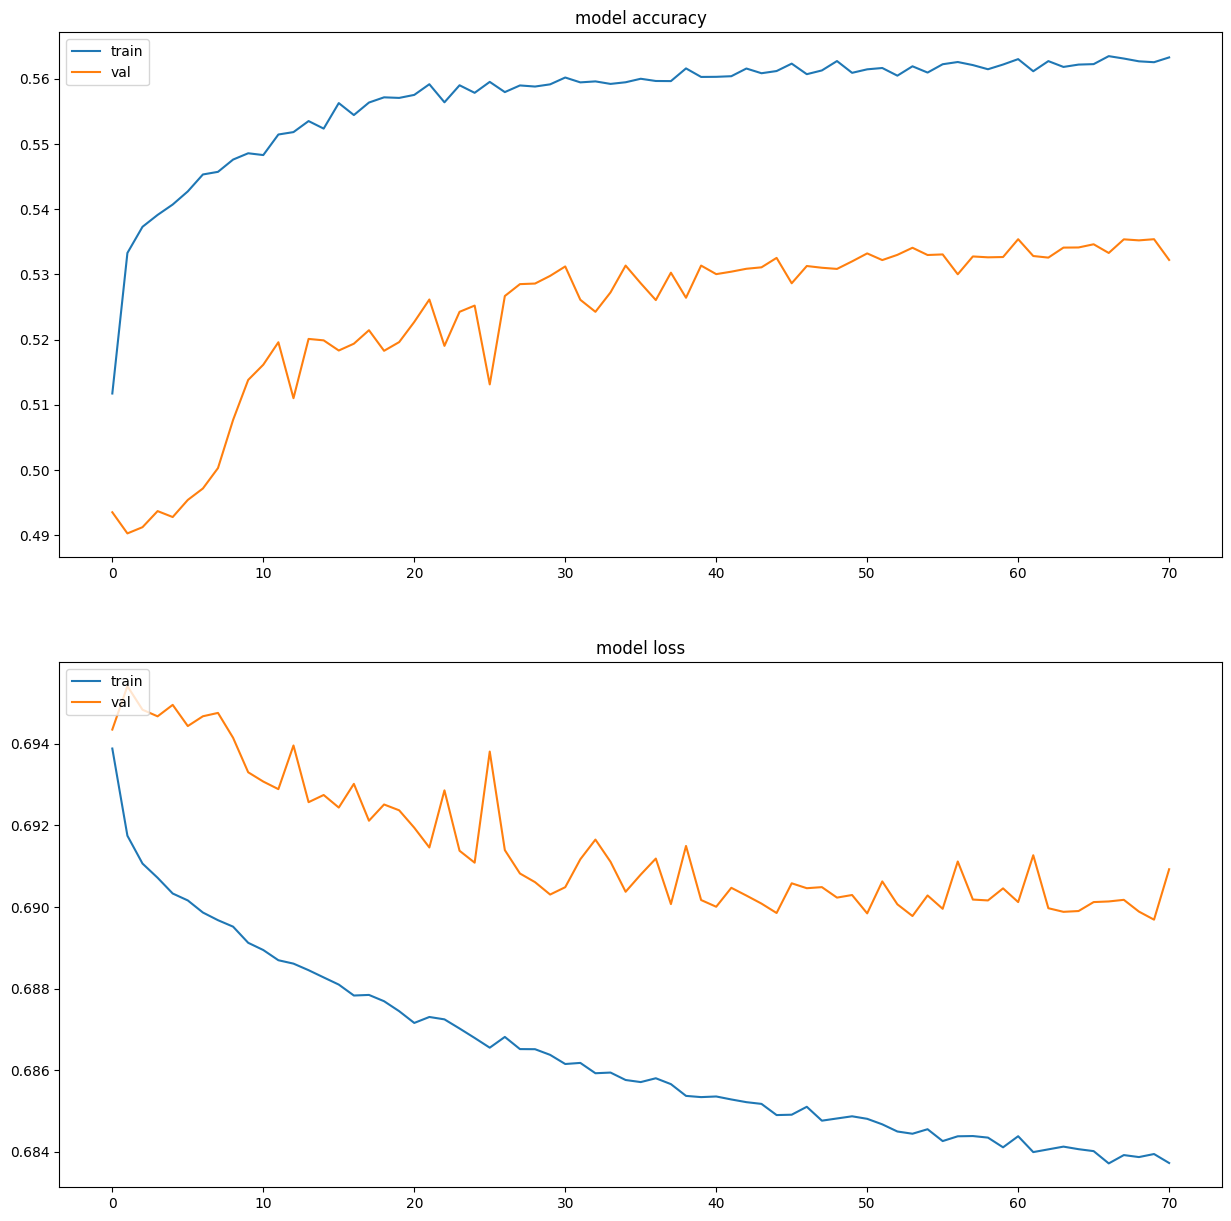

In [16]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,1, figsize = (15,15))
axs = axs.flatten()
axs[0].plot(history.history['binary_accuracy'])
axs[0].plot(history.history['val_binary_accuracy'])
axs[0].set_title('model accuracy')

axs[0].legend(['train', 'val'], loc='upper left')

# summarize history for loss
axs[1].plot(history.history['loss'])
axs[1].plot(history.history['val_loss'])
axs[1].set_title('model loss')

axs[1].legend(['train', 'val'], loc='upper left')


In [ ]:
import numpy as np

# Define the standard deviation of the random noise
noise_std = 100

# Add random noise to the data
X_train_noisy = X_train + np.random.normal(loc=0.0, scale=noise_std, size=X_train.shape)

# Clip the noisy data to ensure that it stays within the same range as the original data
X_train_noisy = np.clip(X_train_noisy, a_min=np.min(X_train), a_max=np.max(X_train))



In [ ]:
import numpy as np
from scipy.fftpack import fft, ifft

# Define the number of samples to generate using Fourier Transform
n_samples = 1000

# Reshape the input data to have shape (N * T, D)
X_train_reshape = np.reshape(X_train, (-1, X_train.shape[-1]))

# Compute the FFT of the input data
X_train_fft = fft(X_train_reshape)

# Generate random samples from the FFT
X_train_fft_samples = np.random.normal(loc=0.0, scale=1.0, size=(n_samples, X_train_fft.shape[1])) + \
                      1j * np.random.normal(loc=0.0, scale=1.0, size=(n_samples, X_train_fft.shape[1]))
                      
# Rescale the samples to have the same variance as the original FFT
X_train_fft_samples = X_train_fft_samples * np.sqrt(np.var(X_train_fft)) / np.sqrt(np.var(X_train_fft_samples))

# Compute the inverse FFT of the samples
X_train_samples = ifft(X_train_fft_samples)

# Reshape the generated samples back to the original shape of the input data
X_train_samples = np.reshape(X_train_samples, (int(5000/600) +1 ,  X_train.shape[1], X_train.shape[2]))

# Stack the generated samples with the original data to obtain the augmented dataset
X_train_augmented = np.concatenate((X_train, X_train_samples), axis=0)


In [ ]:
import numpy as np
from statsmodels.tsa.ar_model import AutoReg

# Define the lag order for the autoregressive model
lag_order = 10

# Load the time series dataset
data = np.reshape(X_train, (-1, X_train.shape[-1])).flatten()
print (data.shape)
# Split the dataset into training and test sets
train_data = data[:1000]
test_data = data[1000:]

# Fit the autoregressive model to the training data
model = AutoReg(train_data, lags=lag_order)
model_fit = model.fit()

# Generate new data using the fitted model
n_samples = 100
new_data = model_fit.predict(start=len(train_data), end=len(train_data)+n_samples-1)

# Print the generated data
dim1 = int(new_data.shape[0] / (X_train.shape[1] * X_train.shape[2]))
new_data = new_data[:dim1]
np.reshape(data , (dim1 , X_train.shape[1] , X_train.shape[2]))


In [ ]:
import numpy as np

# create a function to flip the time series data along its temporal axis
def flip_data(x):
    return np.flip(x, axis=1)

# extract the indices of samples in Y_train that have a value of 1
flip_indices = np.where(Y_train == 1)[0]

# flip the corresponding samples in X_train using boolean indexing
flipped_X_train = flip_data(X_train[flip_indices])

# append the flipped data to X_train and Y_train
X_augmented = np.concatenate([X_train, flipped_X_train], axis=0)
Y_augmented = np.concatenate([Y_train, np.ones((len(flip_indices) , 1))], axis=0)

# shuffle the augmented data
indices = np.arange(X_augmented.shape[0])
np.random.shuffle(indices)
X_augmented = X_augmented[indices]
Y_augmented = Y_augmented[indices]

In [ ]:
import keras.backend as K
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision
